In [7]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

# Use GPU/MPS if available; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# For Apple Silicon, if using MPS (PyTorch 1.12+), you might do:
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


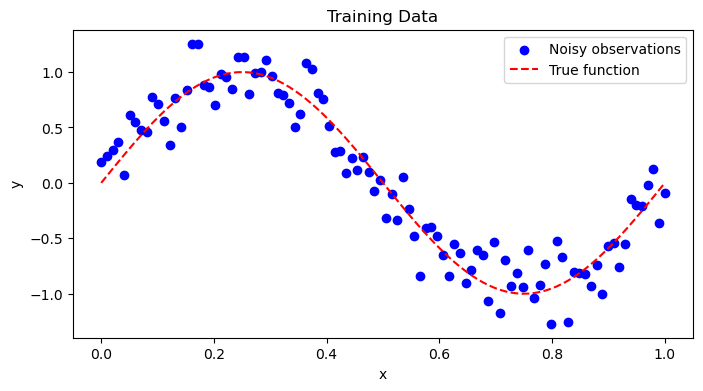

In [8]:
# Generate training data
train_x = torch.linspace(0, 1, 100).to(device)
train_y = torch.sin(train_x * (2 * math.pi)) + 0.2 * torch.randn(train_x.size()).to(device)

# Plot the training data
plt.figure(figsize=(8, 4))
plt.scatter(train_x.cpu(), train_y.cpu(), color="b", label="Noisy observations")
plt.plot(train_x.cpu(), torch.sin(train_x * (2 * math.pi)).cpu(), "r--", label="True function")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Training Data")
plt.legend()
plt.show()


In [9]:
class VariationalGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # Define the variational distribution (Cholesky parameterization)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        # Define the variational strategy. Setting learn_inducing_locations=True will optimize the inducing inputs.
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(VariationalGPModel, self).__init__(variational_strategy)
        
        # Define mean and covariance modules
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Select inducing points (e.g., a subset of training points)
inducing_points = train_x.unsqueeze(-1)[::10]  # take every 10th point, shape: [10, 1]
model = VariationalGPModel(inducing_points.to(device))
model = model.to(device)

# Define the likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)


In [10]:
# Use the VariationalELBO loss provided by GPyTorch
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# Set the model and likelihood into training mode
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

training_iterations = 300

for i in range(training_iterations):
    optimizer.zero_grad()
    # Forward pass: get output from model
    output = model(train_x.unsqueeze(-1))
    # Compute loss and backpropagate gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    if i % 25 == 0:
        print(f'Iteration {i}/{training_iterations} - Loss: {loss.item():.3f}')
    
    optimizer.step()


Iteration 0/300 - Loss: 1.601
Iteration 25/300 - Loss: 1.084
Iteration 50/300 - Loss: 0.907
Iteration 75/300 - Loss: 0.791
Iteration 100/300 - Loss: 0.695
Iteration 125/300 - Loss: 0.586
Iteration 150/300 - Loss: 0.437
Iteration 175/300 - Loss: 0.296
Iteration 200/300 - Loss: 0.189
Iteration 225/300 - Loss: 0.107
Iteration 250/300 - Loss: 0.035
Iteration 275/300 - Loss: -0.007


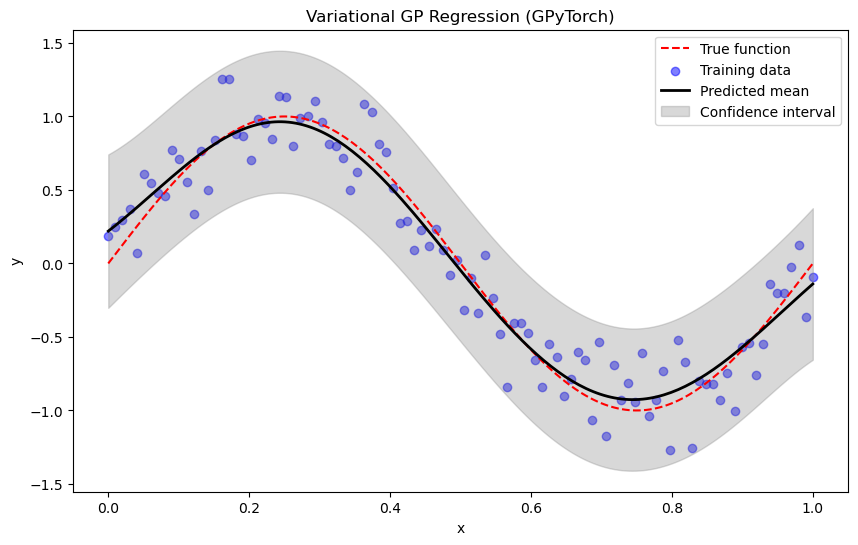

In [11]:
# Set into evaluation mode
model.eval()
likelihood.eval()

# Create test points
test_x = torch.linspace(0, 1, 200).to(device)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictive_dist = likelihood(model(test_x.unsqueeze(-1)))

# Get mean and confidence intervals
mean = predictive_dist.mean.cpu()
lower, upper = predictive_dist.confidence_region()
lower = lower.cpu()
upper = upper.cpu()

# Plot predictions with uncertainty
plt.figure(figsize=(10, 6))
plt.plot(test_x.cpu(), torch.sin(test_x * (2 * math.pi)).cpu(), 'r--', label="True function")
plt.scatter(train_x.cpu(), train_y.cpu(), color="b", alpha=0.5, label="Training data")
plt.plot(test_x.cpu(), mean, 'k', lw=2, label="Predicted mean")
plt.fill_between(test_x.cpu(), lower, upper, color="gray", alpha=0.3, label="Confidence interval")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Variational GP Regression (GPyTorch)")
plt.legend()
plt.show()
